## 1. Exploration des données (blocs 1 à 4)
1. **Charger et explorer le dataset Heart Disease UCI**

In [1]:
# Bloc 1 : Importer les bibliothèques et charger les données

# Importer les bibliothèques nécessaires
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import streamlit as st
import joblib
import warnings

from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline


In [2]:
# Bloc 2 : Chargement du dataset

# Charger le dataset
df = pd.read_csv('heart_disease_uci.csv')

# Reclasser la colonne 'num' en deux catégories : '0' pour 'pas malade' et '1' pour 'malade'
df['num_binary'] = df['num'].apply(lambda x: 0 if x == 0 else 1)

# Examiner les premières lignes du dataset
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,num_binary
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,0


In [3]:
# Bloc 3 : Résumer les statistiques descriptives des caractéristiques
df.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num,num_binary
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652,0.553261
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693,0.497426
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000,1.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000,1.000000


In [4]:
# Bloc 4 : Vérifier les types de données des colonnes
df.dtypes

id              int64
age             int64
sex            object
dataset        object
cp             object
trestbps      float64
chol          float64
fbs            object
restecg        object
thalch        float64
exang          object
oldpeak       float64
slope          object
ca            float64
thal           object
num             int64
num_binary      int64
dtype: object

## 2. Préparation des données (blocs 5 à 13)
1. **Nettoyer les données** : traitement des valeurs manquantes, normalisation des caractéristiques
2. **Diviser les données en ensembles d'entraînement et de test**

In [5]:
# Bloc 5 : Conversion des valeurs

# Convertir les colonnes non numériques en numériques
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['cp'] = df['cp'].astype('category').cat.codes

# Examiner à nouveau les types de données des colonnes
print(df.dtypes)

id              int64
age             int64
sex             int64
dataset        object
cp               int8
trestbps      float64
chol          float64
fbs            object
restecg        object
thalch        float64
exang          object
oldpeak       float64
slope          object
ca            float64
thal           object
num             int64
num_binary      int64
dtype: object


In [6]:
# Bloc 6 : Identification des valeurs nulles

df.isnull().sum()

id              0
age             0
sex             0
dataset         0
cp              0
trestbps       59
chol           30
fbs            90
restecg         2
thalch         55
exang          55
oldpeak        62
slope         309
ca            611
thal          486
num             0
num_binary      0
dtype: int64

In [7]:
# Bloc 7 : Suppression des lignes comportant des valeurs nulles

# Copier le DataFrame dans un autre DataFrame
df_copy = df.copy()

# Supprimer toutes les lignes contenant des valeurs nulles dans df
df = df.dropna()

# Contrôler que la dataframe ne comporte plus de ligne ayany des valeurs nulles
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps      0
chol          0
fbs           0
restecg       0
thalch        0
exang         0
oldpeak       0
slope         0
ca            0
thal          0
num           0
num_binary    0
dtype: int64

In [8]:
# Bloc 8 : répartition des valeurs uniques en pourcentage
proportions = df['num'].value_counts(normalize=True)

# Afficher les proportions
print(proportions)

# Calcul de la baseline du modèle naïf
baseline = proportions.max() * 100
print(f"La baseline d'un modèle naïf, qui prédirait toujours la classe majoritaire, est de {baseline:.2f} pourcent.")

num
0    0.535117
1    0.187291
2    0.117057
3    0.117057
4    0.043478
Name: proportion, dtype: float64
La baseline d'un modèle naïf, qui prédirait toujours la classe majoritaire, est de 53.51 pourcent.


In [9]:
# Bloc 9 : contrôle des données
df

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,num_binary
0,1,63,1,Cleveland,3,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,0
1,2,67,1,Cleveland,0,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,1
2,3,67,1,Cleveland,0,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,1
3,4,37,1,Cleveland,2,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,0
4,5,41,0,Cleveland,1,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,300,68,1,Cleveland,0,144.0,193.0,True,normal,141.0,False,3.4,flat,2.0,reversable defect,2,1
300,301,57,1,Cleveland,0,130.0,131.0,False,normal,115.0,True,1.2,flat,1.0,reversable defect,3,1
301,302,57,0,Cleveland,1,130.0,236.0,False,lv hypertrophy,174.0,False,0.0,flat,1.0,normal,1,1
508,509,47,1,Hungary,0,150.0,226.0,False,normal,98.0,True,1.5,flat,0.0,reversable defect,1,1


In [10]:
# Bloc 10 : Préparation des données d'entrainement et cible en sépararant les prédisteurs (features) et les étiquettes (labels)

# Colonnes numériques et non numériques à partir du DataFrame
X = df.drop(columns=['num', 'num_binary','id'])  # Exclure les colonnes 'num' et 'num_binary' des prédicteurs
y = df['num_binary']  # Utiliser la nouvelle colonne binaire comme cible


In [11]:
# Bloc 11 : Séparation des données d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((239, 14), (60, 14), (239,), (60,))

In [12]:
# Bloc 12 : Nettoyage des données et encodage des colonnes non numériques et normalisation via un pipeline de prétraitement

# Colonnes numériques et non numériques à partir du DataFrame
numeric_cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'thalch', 'oldpeak']
categorical_cols = ['dataset', 'fbs', 'restecg', 'exang']

# Pipeline pour les colonnes numériques : imputation et normalisation
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline pour les colonnes catégorielles : encodage OneHotEncoder
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des valeurs manquantes
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline de prétraitement pour appliquer séparément les transformations
preproc_pipe = make_column_transformer(
    (num_pipe, numeric_cols),
    (cat_pipe, categorical_cols),
    remainder='drop'  # Ignorer les colonnes non spécifiées
)

preproc_pipe

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'sex', 'cp', 'trestbps', 'chol',
                                  'thalch', 'oldpeak']),
                                ('pipeline-2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['dataset', 'fbs', 'restecg', 'exang'])])

In [13]:
# Bloc 13 : Préparation des données

# Transformation selon les spécifications du pipeline
X_train_transformed = preproc_pipe.fit_transform(X_train)

#Vérification de la dimension des données transformées
X_train_transformed.shape

(239, 17)

## 3. Entrainer les modèles (blocs 14 à 23)
1. **Initialilation des modèles de machine learning**
2. **Evaluation de la performance des modèles par validation croisée**
3. **Optimisation des hyperparamètres des modèles**
4. **Récupération du meilleur modèle**
5. **Prédiction**

In [14]:
# Bloc 14 : Initialisation des modèles de Machine Learning

logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

models = [logistic_regression, decision_tree, random_forest ]
models

[LogisticRegression(max_iter=1000, random_state=42),
 DecisionTreeClassifier(random_state=42),
 RandomForestClassifier(random_state=42)]

In [15]:
# Bloc 15 : Evaluation de la performance des modèles par validation croisée

# Création du modèle et cross-validation
results = []
for model in models:
    pipe = make_pipeline(preproc_pipe, model)
    score = cross_validate(pipe, X_train, y_train, cv=5, scoring='accuracy', return_train_score=True)
    
    mean_test_score = score['test_score'].mean()
    
    # Ajouter le type du modèle et ses résultats à la liste
    results.append({
        'Model': type(model).__name__,
        'Test Score (mean)': mean_test_score,
    })

# Transformer les résultats en un DataFrame pour une meilleure visualisation
results_df = pd.DataFrame(results)

# Afficher
print(results_df)


                    Model  Test Score (mean)
0      LogisticRegression           0.786702
1  DecisionTreeClassifier           0.694858
2  RandomForestClassifier           0.761436


In [16]:
# Bloc 16 : Optimisation des hyperparamètres du modèle de régression logistique intégrant un pipeline de prétraitement

# Désactiver les warnings
warnings.filterwarnings('ignore')

# Définir la grille de paramètres pour la régression logistique
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  
    'logisticregression__solver': ['liblinear', 'lbfgs'],  
    'logisticregression__penalty': ['l1', 'l2'],  
}

# Créer un pipeline avec prétraitement et régression logistique
pipe = make_pipeline(preproc_pipe, logistic_regression)

# Initialiser GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)

# Ajuster la recherche par grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Obtenir les meilleurs paramètres et le meilleur score
best_params = grid_search.best_params_
best_grid_score = grid_search.best_score_

# Définir le score avant optimisation (à partir des résultats de la validation croisée précédente)
previous_score = results_df.loc[results_df['Model'] == 'LogisticRegression', 'Test Score (mean)'].values[0]

# Afficher les résultats
print(f"Meilleurs paramètres : {best_params}")

# Comparer les scores et réintégrer la phrase corrigée
print(f"Le score du meilleur modèle avant optimisation est de {previous_score:.4f}")
print(f"Le score validé par croisement avant optimisation du modèle de régression logistique est de {previous_score:.4f}")
print(f"Le score validé par croisement après optimisation du modèle de régression logistique est de {best_grid_score:.4f}")


Meilleurs paramètres : {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Le score du meilleur modèle avant optimisation est de 0.7867
Le score validé par croisement avant optimisation du modèle de régression logistique est de 0.7867
Le score validé par croisement après optimisation du modèle de régression logistique est de 0.7910


In [17]:
# Bloc 17 : Optimisation des hyperparamètres du modèle RandomForestClassifier intégrant un pipeline de prétraitement

# Désactiver les warnings
warnings.filterwarnings('ignore')

# Définir une grille de paramètres plus étendue pour RandomForestClassifier
param_grid_forest = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2']
}

# Créer un pipeline avec prétraitement et RandomForestClassifier
pipe_forest = make_pipeline(preproc_pipe, RandomForestClassifier(random_state=42))

# Initialiser GridSearchCV pour la forêt aléatoire
grid_search_forest = GridSearchCV(pipe_forest, param_grid_forest, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)

# Ajuster la recherche par grille sur les données d'entraînement
grid_search_forest.fit(X_train, y_train)

# Obtenir les meilleurs paramètres et le meilleur score
best_params_forest = grid_search_forest.best_params_
best_grid_score_forest = grid_search_forest.best_score_

# Définir le score avant optimisation
previous_score_forest = results_df.loc[results_df['Model'] == 'RandomForestClassifier', 'Test Score (mean)'].values[0]

# Afficher les résultats
print(f"Meilleurs paramètres : {best_params_forest}")
print(f"Le score du meilleur modèle avant optimisation est de {previous_score:.4f}")
print(f"Le score validé par croisement avant optimisation du modèle RandomForestClassifier est de {previous_score_forest:.4f}")
print(f"Le score validé par croisement après optimisation du modèle RandomForestClassifier est de {best_grid_score_forest:.4f}")

# Réactiver les warnings
warnings.filterwarnings('default')


Meilleurs paramètres : {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 200}
Le score du meilleur modèle avant optimisation est de 0.7867
Le score validé par croisement avant optimisation du modèle RandomForestClassifier est de 0.7614
Le score validé par croisement après optimisation du modèle RandomForestClassifier est de 0.7741


In [18]:
# Bloc 18 : Optimisation des hyperparamètres du modèle DecisionTreeClassifier intégrant un pipeline de prétraitement

# Désactiver les warnings
warnings.filterwarnings('ignore')

# Instancier le modèle DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

# Définir la grille de paramètres pour l'arbre de décision
param_grid_tree = {
    'decisiontreeclassifier__max_depth': [None, 10, 20],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
}

# Créer un pipeline avec prétraitement et DecisionTreeClassifier
pipe_tree = make_pipeline(preproc_pipe, decision_tree_classifier)

# Initialiser GridSearchCV pour l'arbre de décision
grid_search_tree = GridSearchCV(pipe_tree, param_grid_tree, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)

# Ajuster la recherche par grille sur les données d'entraînement
grid_search_tree.fit(X_train, y_train)

# Obtenir les meilleurs paramètres et le meilleur score
best_params_tree = grid_search_tree.best_params_
best_grid_score_tree = grid_search_tree.best_score_

# Définir le score avant optimisation
previous_score_tree = results_df.loc[results_df['Model'] == 'DecisionTreeClassifier', 'Test Score (mean)'].values[0]

# Afficher les résultats
print(f"Meilleurs paramètres pour DecisionTreeClassifier : {best_params_tree}")

# Comparer les scores
print(f"Le score du meilleur modèle avant optimisation est de {previous_score:.4f}") 
print(f"Le score validé par croisement avant optimisation du modèle DecisionTreeClassifier est de {previous_score_tree:.4f}")
print(f"Le score validé par croisement après optimisation du modèle DecisionTreeClassifier est de {best_grid_score_tree:.4f}")


Meilleurs paramètres pour DecisionTreeClassifier : {'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__min_samples_split': 10}
Le score du meilleur modèle avant optimisation est de 0.7867
Le score validé par croisement avant optimisation du modèle DecisionTreeClassifier est de 0.6949
Le score validé par croisement après optimisation du modèle DecisionTreeClassifier est de 0.7159


In [19]:
# Bloc 19 : Extraction du meilleur modèle

# Initialiser les meilleures variables pour la comparaison
best_scores = {
    'Logistic Regression': best_grid_score,           # Score après optimisation pour Logistic Regression
    'Random Forest': grid_search_forest.best_score_,  # Score après optimisation pour Random Forest
    'Decision Tree': grid_search_tree.best_score_     # Score après optimisation pour Decision Tree
}

# Trouver le meilleur modèle
best_model_name = max(best_scores, key=best_scores.get)  # Nom du modèle avec le meilleur score
best_score_overall = best_scores[best_model_name]          # Meilleur score

# Enregistrer le modèle correspondant
if best_model_name == 'Random Forest':
    best_model = grid_search_forest.best_estimator_
elif best_model_name == 'Decision Tree':
    best_model = grid_search_tree.best_estimator_
else:
    best_model = grid_search.best_estimator_

# Affichage des résultats
if best_model is not None:
    print(f"Le meilleur modèle après optimisation est : {best_model_name} avec un score de {best_score_overall:.4f}")

    # Enregistrement du meilleur modèle
    joblib.dump(best_model, 'best_model_binaire.pkl')

    # Affichage
    print("Ce modèle est sauvegardé sous 'best_model_binaire.pkl'")


Le meilleur modèle après optimisation est : Logistic Regression avec un score de 0.7910
Ce modèle est sauvegardé sous 'best_model_binaire.pkl'


In [20]:
# Bloc 20 : Récupération du meilleur modèle optimisé à partir du fichier sauvegardé

loaded_model = joblib.load('best_model_binaire.pkl')


In [21]:
# bloc 21 : Récupération de la première ligne du DataFrame

X_test.iloc[[0]]

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
285,58,1,Cleveland,0,114.0,318.0,False,st-t abnormality,140.0,False,4.4,downsloping,3.0,fixed defect


In [22]:
# Bloc 22 : Obtenir la prédiction du modèle pour la première observation de l'ensemble de test

loaded_model.predict(X_test.iloc[[0]])

array([1], dtype=int64)

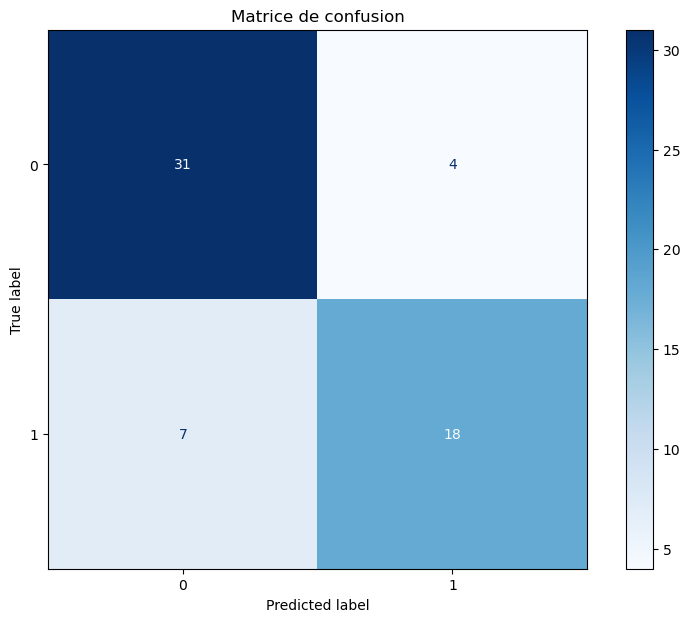

In [23]:
# Bloc 23 : visualisation des performances du modèle de classification

# Prédictions sur l'ensemble de test
y_pred = loaded_model.predict(X_test)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Créer un objet ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=loaded_model.classes_)

# Afficher
fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Matrice de confusion")
plt.show()